# Gaussian Mixture Models

The k-means clustering model explored in the lecture notebook is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application. In particular, the non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations. In this notebook we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering.

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. 

In [1]:
# Standard imports

import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
# Enable inline plotting
%matplotlib inline
# matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

Let's create a dataset with 400 samples that are distributed around 4 centers with 0.6 standard deviation. We will use the function [`make_blobs` ](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)that generates isotropic Gaussian blobs for clustering.

In [3]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

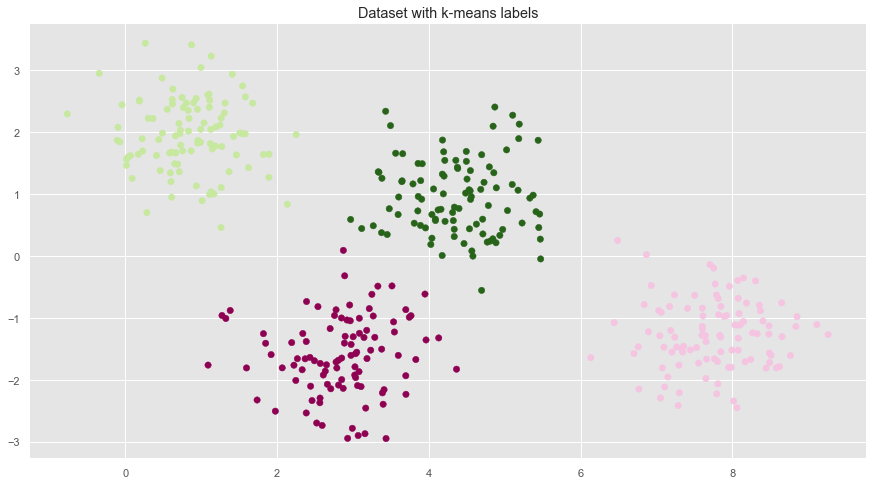

In [5]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='PiYG')
plt.title('Dataset with k-means labels');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

In [6]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='PiYG', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

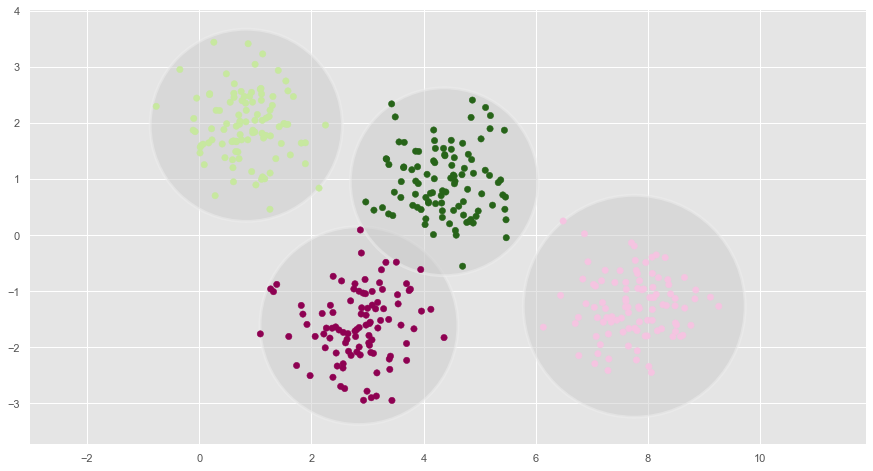

In [7]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models must be **circular**: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

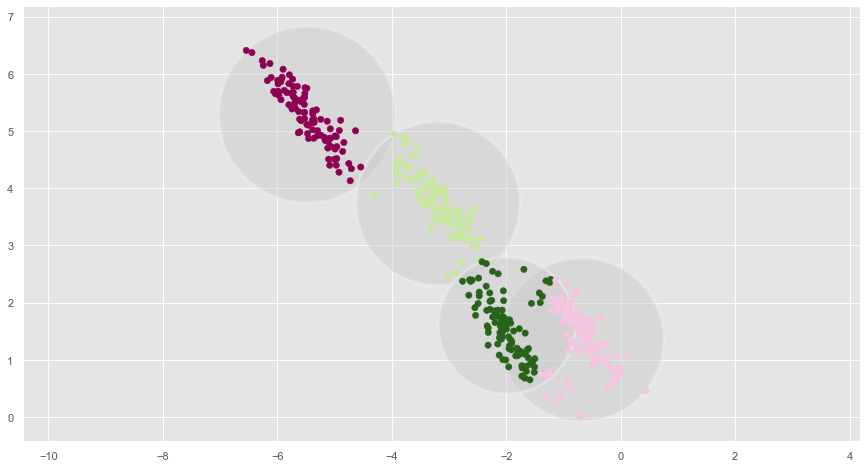

In [8]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched);

By eye, we recognize that these transformed clusters are **non-circular,** and thus circular clusters would be a **poor fit**. Nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. This results in a mixing of cluster assignments where the resulting circles overlap.

A **Gaussian mixture model (GMM)** attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

In [9]:
from sklearn.mixture import GaussianMixture, GMM 

gmm = GaussianMixture (n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='PiYG');
plt.title('Dataset with GMM labels');

ImportError: cannot import name 'GMM' from 'sklearn.mixture' (C:\Users\bjark\Anaconda3\lib\site-packages\sklearn\mixture\__init__.py)

But because GMM contains a probabilistic model under the hood, it is also possible to find **probabilistic cluster assignments**. In Scikit-Learn this is done using the [`predict_proba`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.libsvm.predict_proba.html)  method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [11]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

NameError: name 'gmm' is not defined

We can visualize this uncertainty by, for example, making the **size of each point proportional to the certainty of its prediction**. Looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

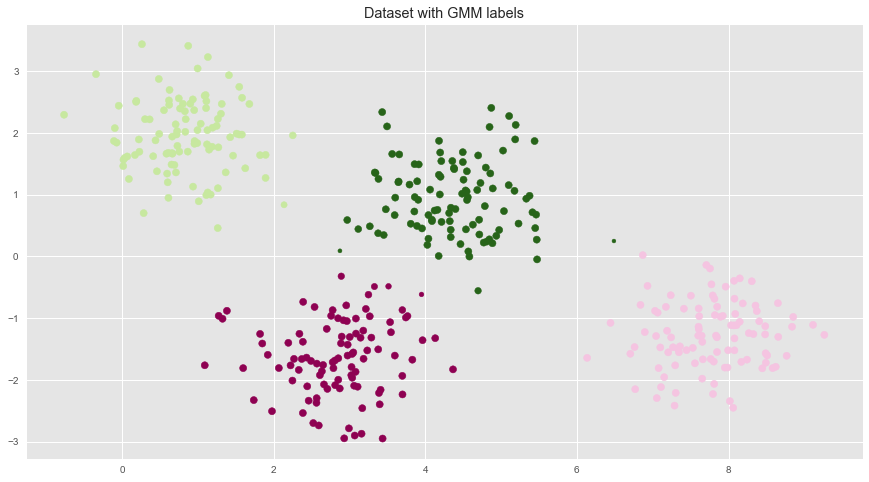

In [10]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='PiYG', s=size);
plt.title('Dataset with GMM labels');

**A GMM will follow the steps [(expectation-maximization (EM) algorithm](http://scikit-learn.org/stable/modules/mixture.html#expectation-maximization)  implementation):**

1. Choose starting guesses for the location and shape
2. Repeat until converged:
    1. E-step: for each point, find weights encoding the probability of membership in each cluster
    2. M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
    
The `GaussianMixture` comes with different options to constrain the covariance of the difference classes estimated: spherical, diagonal, tied or full covariance.
    
    
The result of this is that each cluster is associated **not with a hard-edged sphere**, but with a smooth **Gaussian model**. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used:

In [11]:
from matplotlib.patches import Ellipse
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='PiYG', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

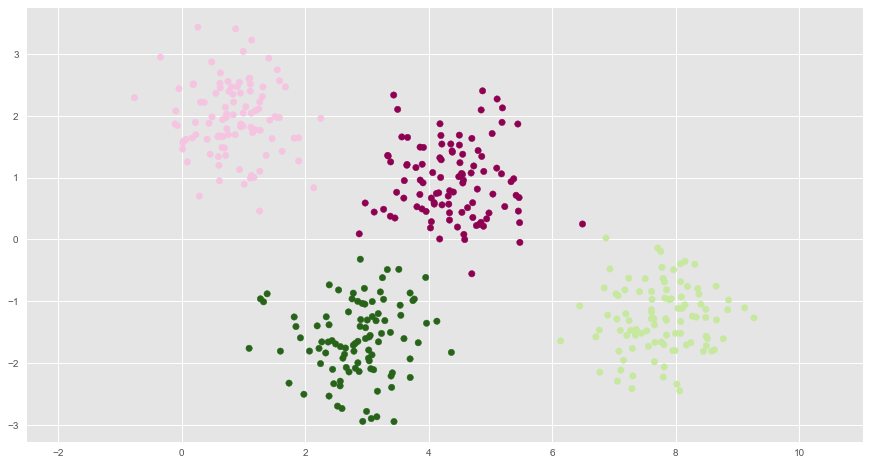

In [12]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

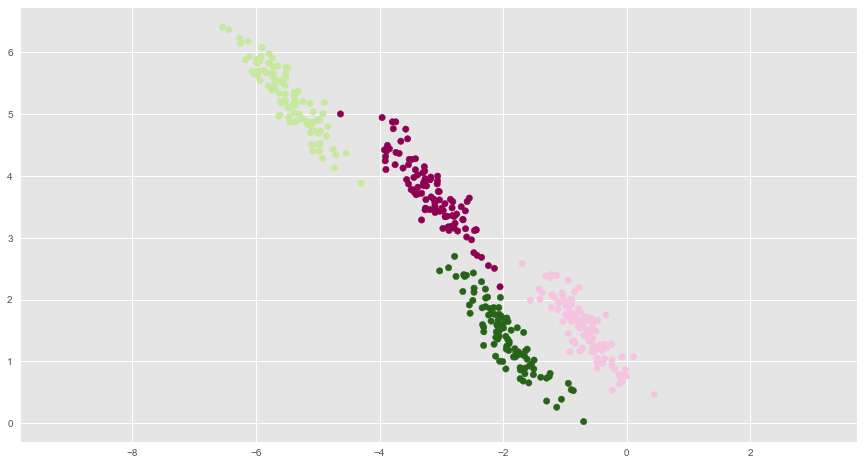

In [13]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

### Covariance type

If you look at the details of the preceding fits, you will see that the **`covariance_type`** option was set differently within each. This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem. 

The default is **`covariance_type="diag"`**, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes. 

A slightly simpler and faster model is **`covariance_type="spherical"`**, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of k-means, though it is not entirely equivalent. 

A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use **`covariance_type="full"`**, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

<img src=http://scikit-learn.org/stable/_images/sphx_glr_plot_gmm_covariances_001.png>

## GMM as Density Estimation

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for **density estimation**. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's `make_moons` function, which we saw in In Depth: K-Means Clustering:

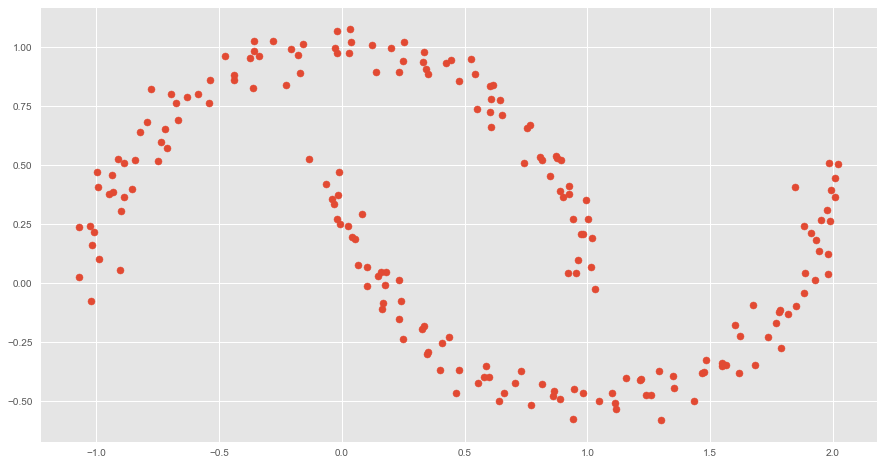

In [14]:
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

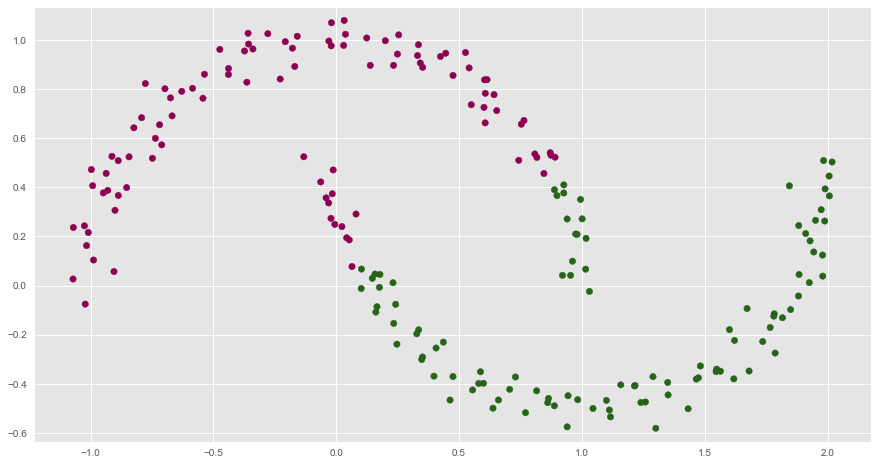

In [15]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

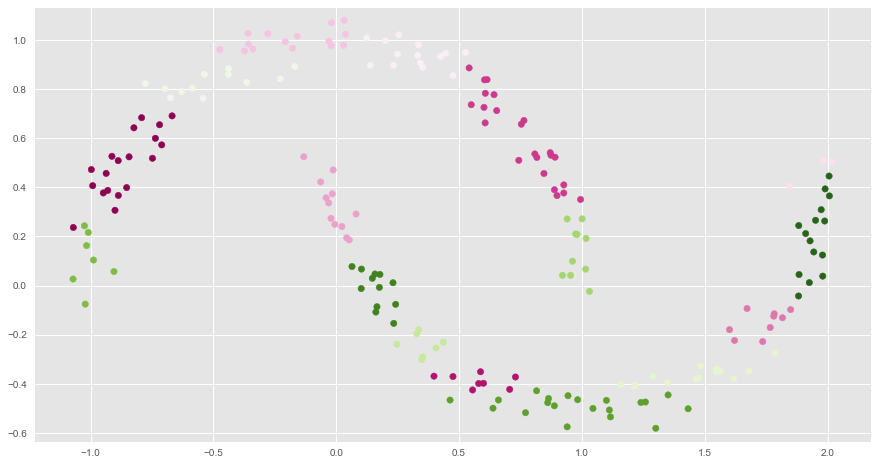

In [16]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

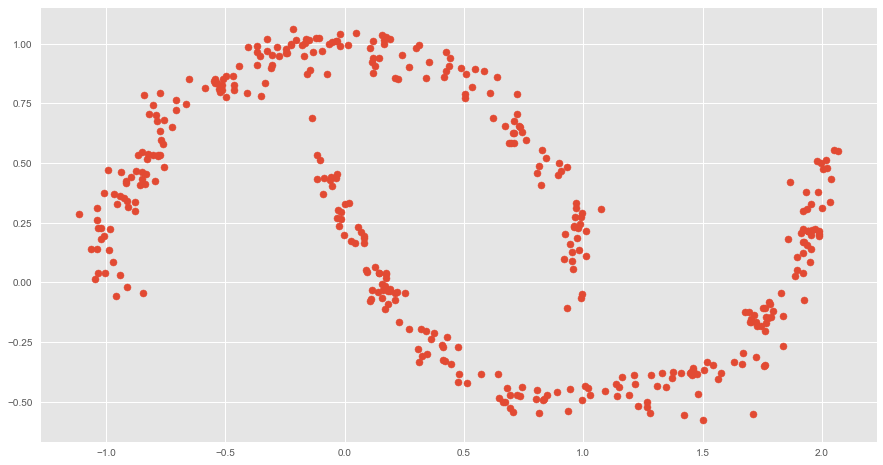

In [17]:
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

Let's go back to our real datasets.

In [42]:
f_points=pd.read_csv("PickUps_June_2016_Brooklyn.csv")
f_points.head()

,Unnamed: 0,pickup_datetime,pickup_longitude,pickup_latitude
0,124,2016-06-09 21:06:00,-74.003128,40.706345
1,139,2016-06-09 21:06:02,-73.987724,40.700386
2,142,2016-06-09 21:06:02,-73.992584,40.689636
3,158,2016-06-09 21:06:42,-73.977707,40.684486
4,186,2016-06-09 21:06:45,-74.004692,40.707169


In [43]:
x=f_points[['pickup_longitude', 'pickup_latitude']]

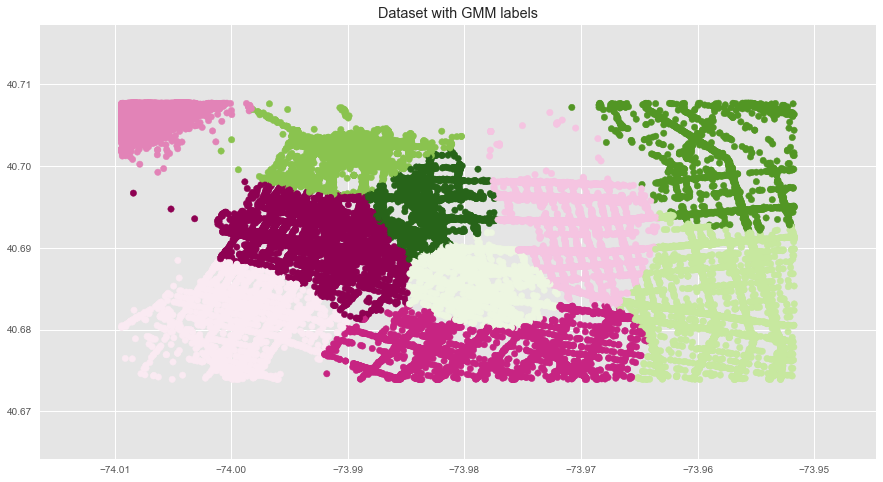

In [44]:
gmm = GaussianMixture(n_components=10).fit(x)
labels = gmm.predict(x)
plt.scatter(x['pickup_longitude'], x['pickup_latitude'], c=labels, s=40, cmap='PiYG');
plt.title('Dataset with GMM labels');

**References**

* https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html